In [3]:
import argparse
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [4]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)


    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=14)
    
    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)
    
    # # Let the horizontal axes labeling appear on top.
    # ax.tick_params(top=True, bottom=False,
    #                labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    #          rotation_mode="anchor")

    # # Turn spines off and create grid.
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="k", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(im.get_array().max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            textcolor_i = int(im.norm(im.get_array()[i, j]) > threshold)
            kw.update(color=textcolors[textcolor_i])
            if valfmt is None:
                text = im.axes.text(j, i, data[i, j], **kw)
            else:
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [11]:
def create_plots(df_type, program, match_type, max_new_qs, outdir):

    # Get matrices of the new phred value and the new nucleotide
    df_new_qs = df_type.pivot(index='qs2', columns='qs1', values='new_qs') \
                        .sort_index(ascending=False)
    df_new_nt = df_type.pivot(index='qs2', columns='qs1', values='new_nt') \
                        .sort_index(ascending=False)


    # Plot the heatmap with the phred values
    fig, ax = plt.subplots(figsize=(15, 15))
    im, cbar = heatmap(
        df_new_qs.to_numpy(), 
        df_new_qs.index,
        df_new_qs.columns, 
        ax=ax,
        cbarlabel="New phred quality score",
        cbar_kw={"shrink": 0.6}, 
        cmap="RdYlGn",
        vmin=0, 
        vmax=max_new_qs,
        )

    # Add titel and axes labels
    nt1 = list(df_type["nt1"])[0]
    nt2 = list(df_type["nt2"])[0]
    ax.set_title(f"{program}, {match_type}", fontsize=20)
    ax.set_xlabel(f"Phred quality score, forward read (nt={nt1})", fontsize=14)
    ax.set_ylabel(f"Phred quality score, reverse read (rev. compl. nt={nt2})",
                fontsize=14)

    # Add the new nucletide as annotation
    texts = annotate_heatmap(im, 
                            df_new_nt.to_numpy(), 
                            valfmt=None, 
                            #textcolors=("white", "black"),
                            threshold=max_new_qs
                            )

    # Save plot
    fig.tight_layout()
    if outdir is not None:
        plt.savefig(f"{outdir}/{program}_{match_type}.png", 
                    dpi='figure', 
                    format="png")
    else:
        plt.show()
    plt.close(fig)

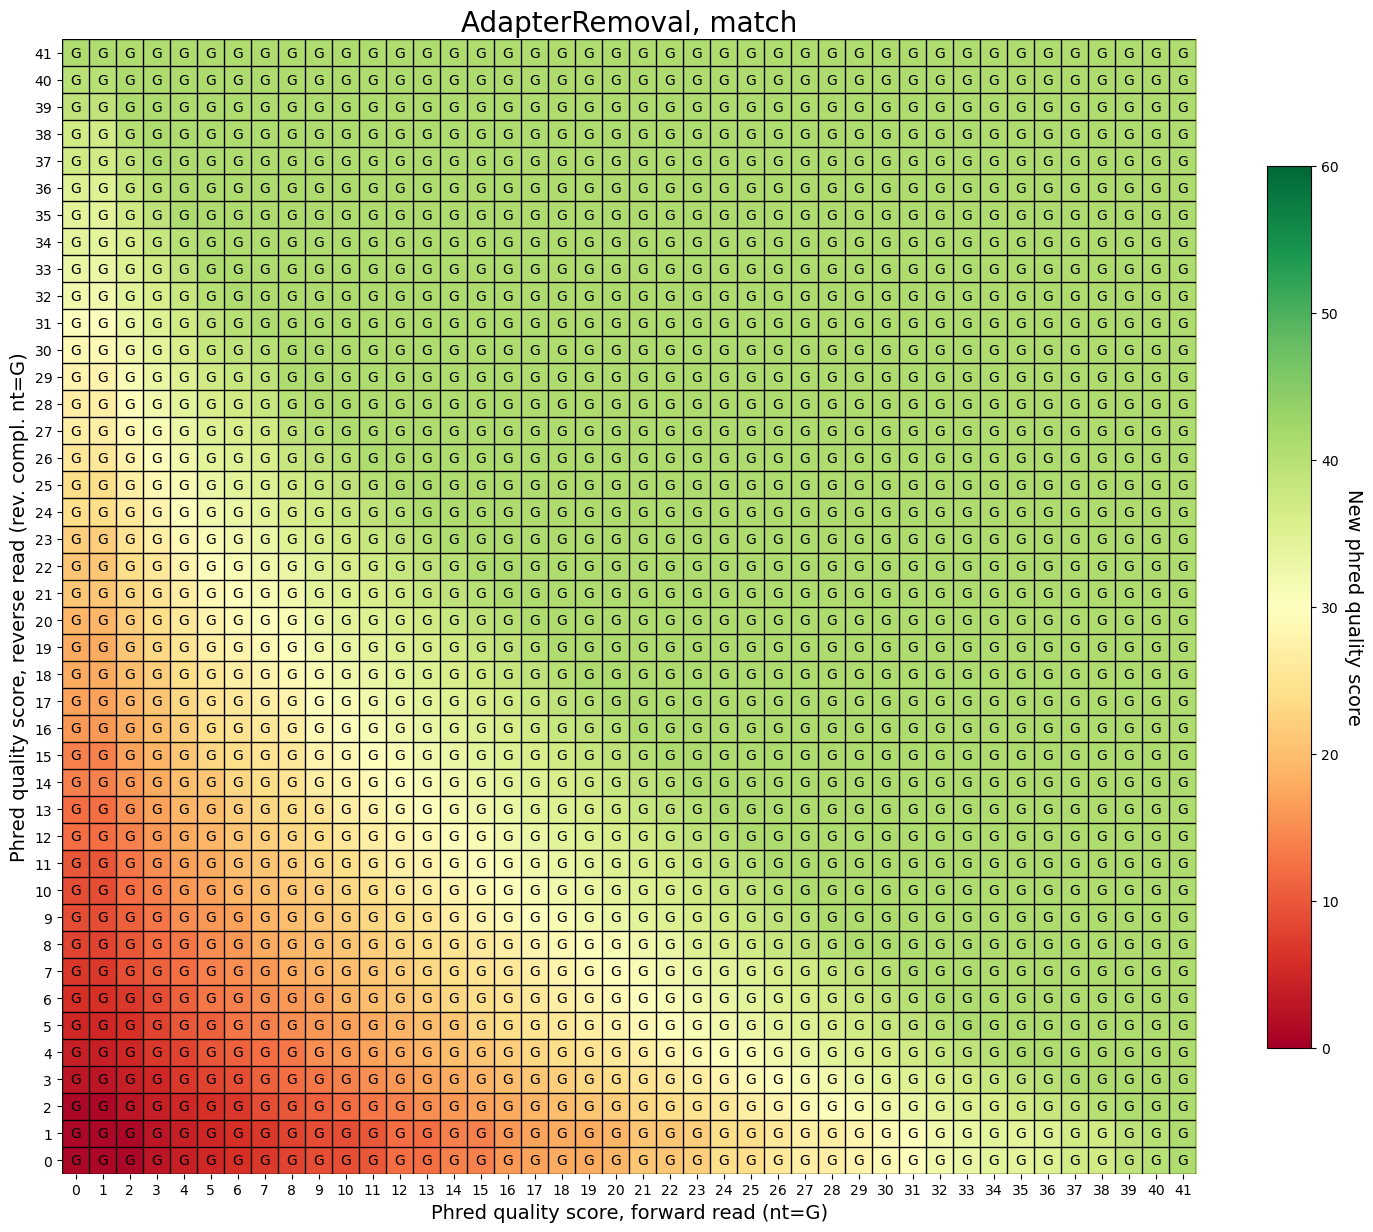

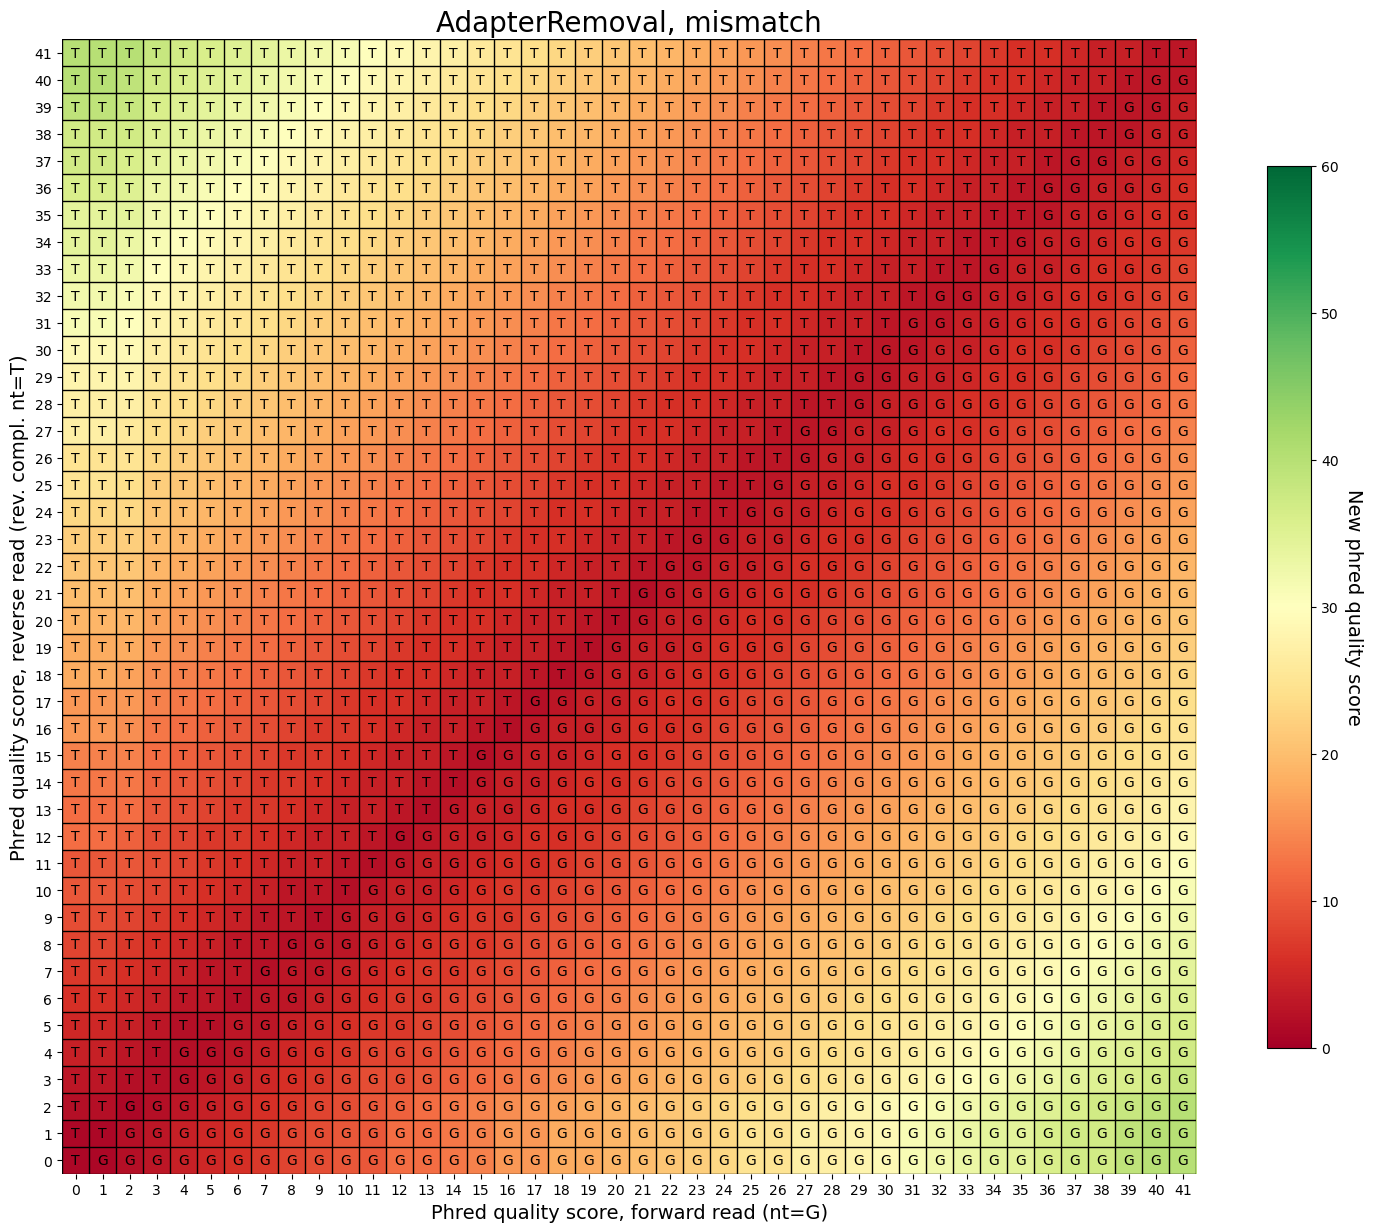

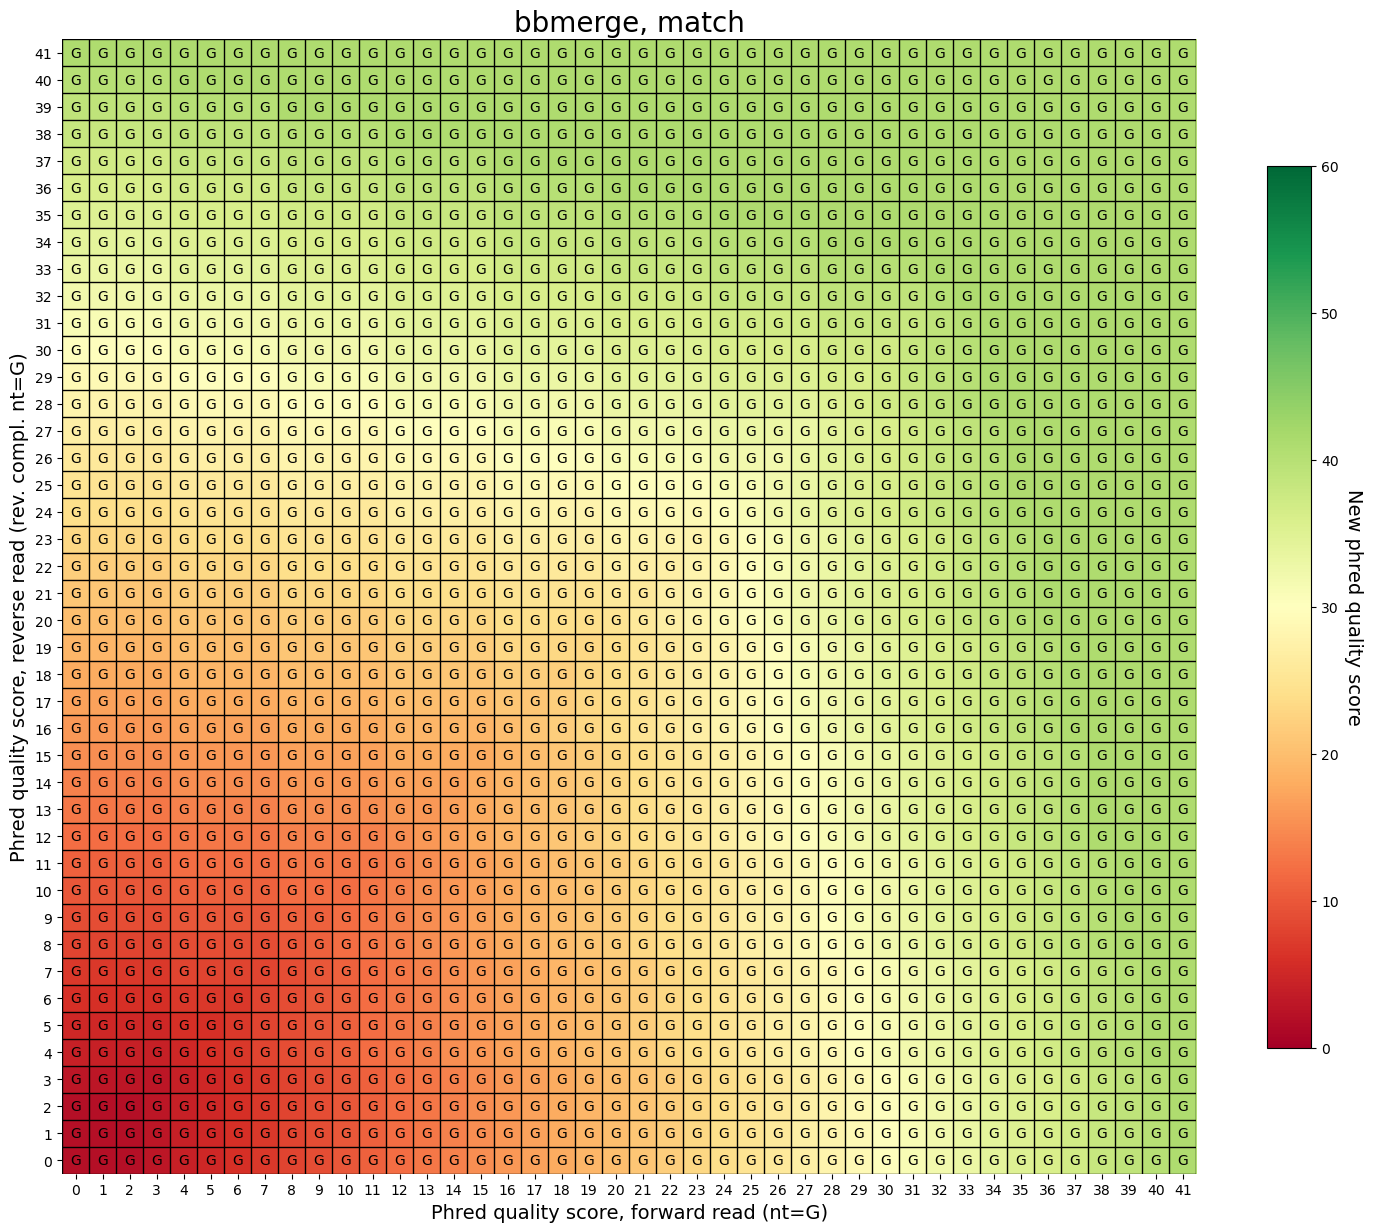

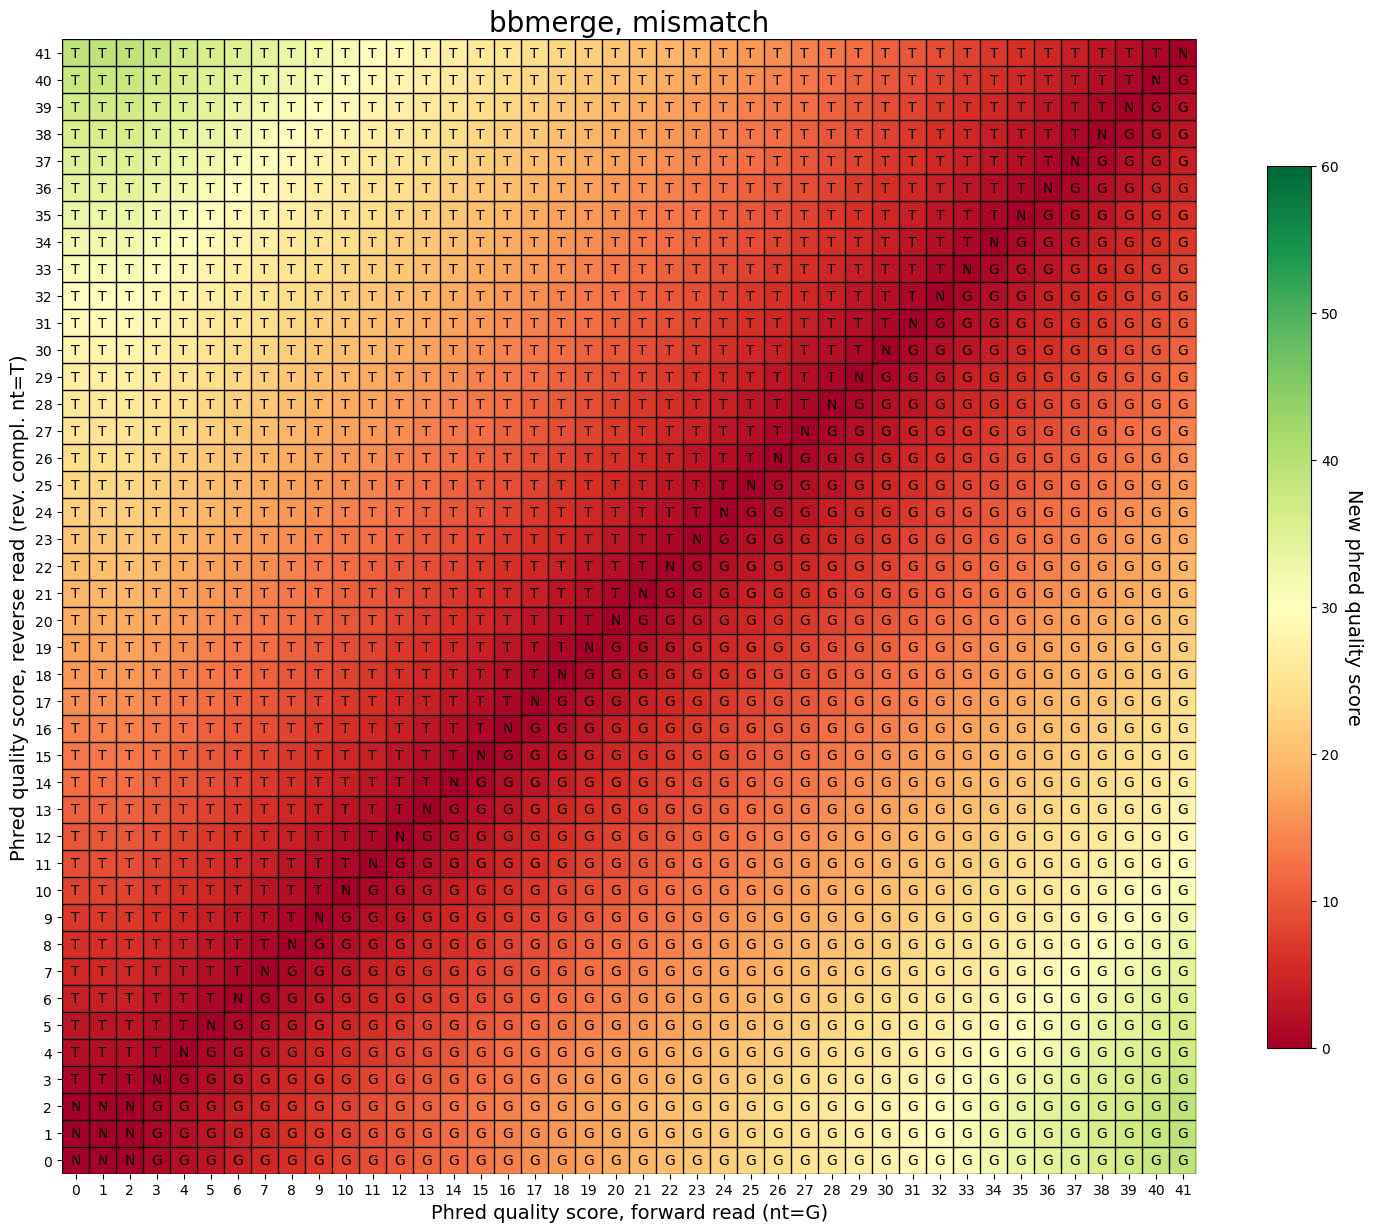

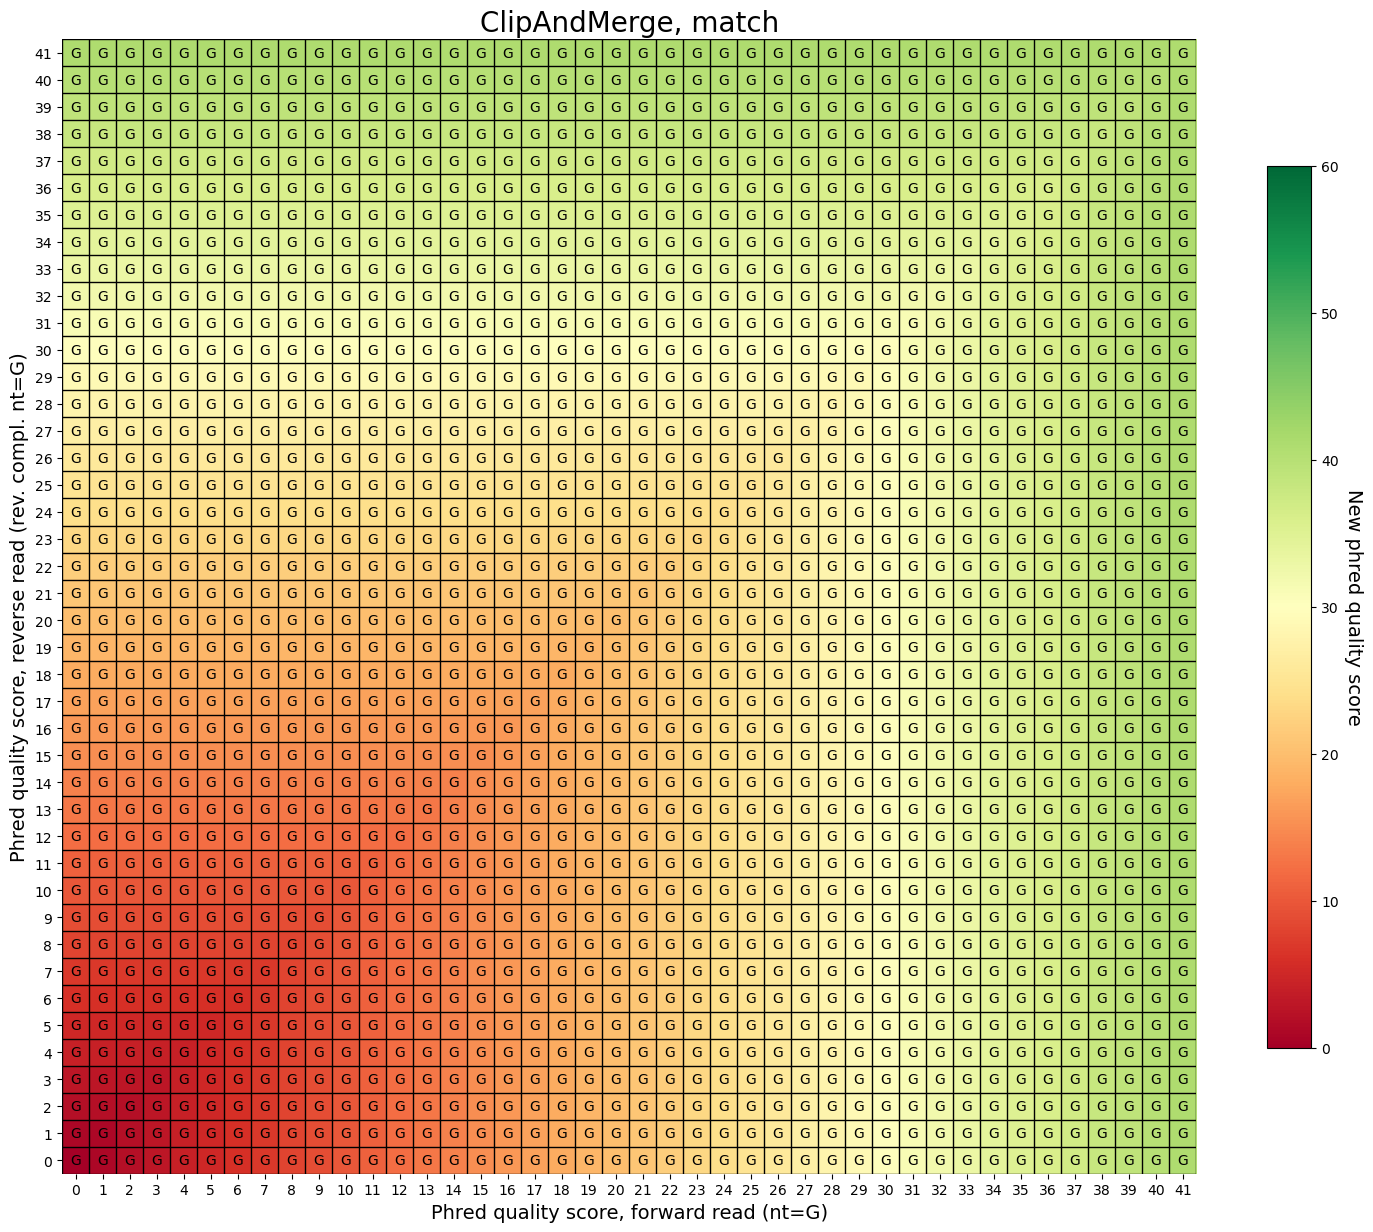

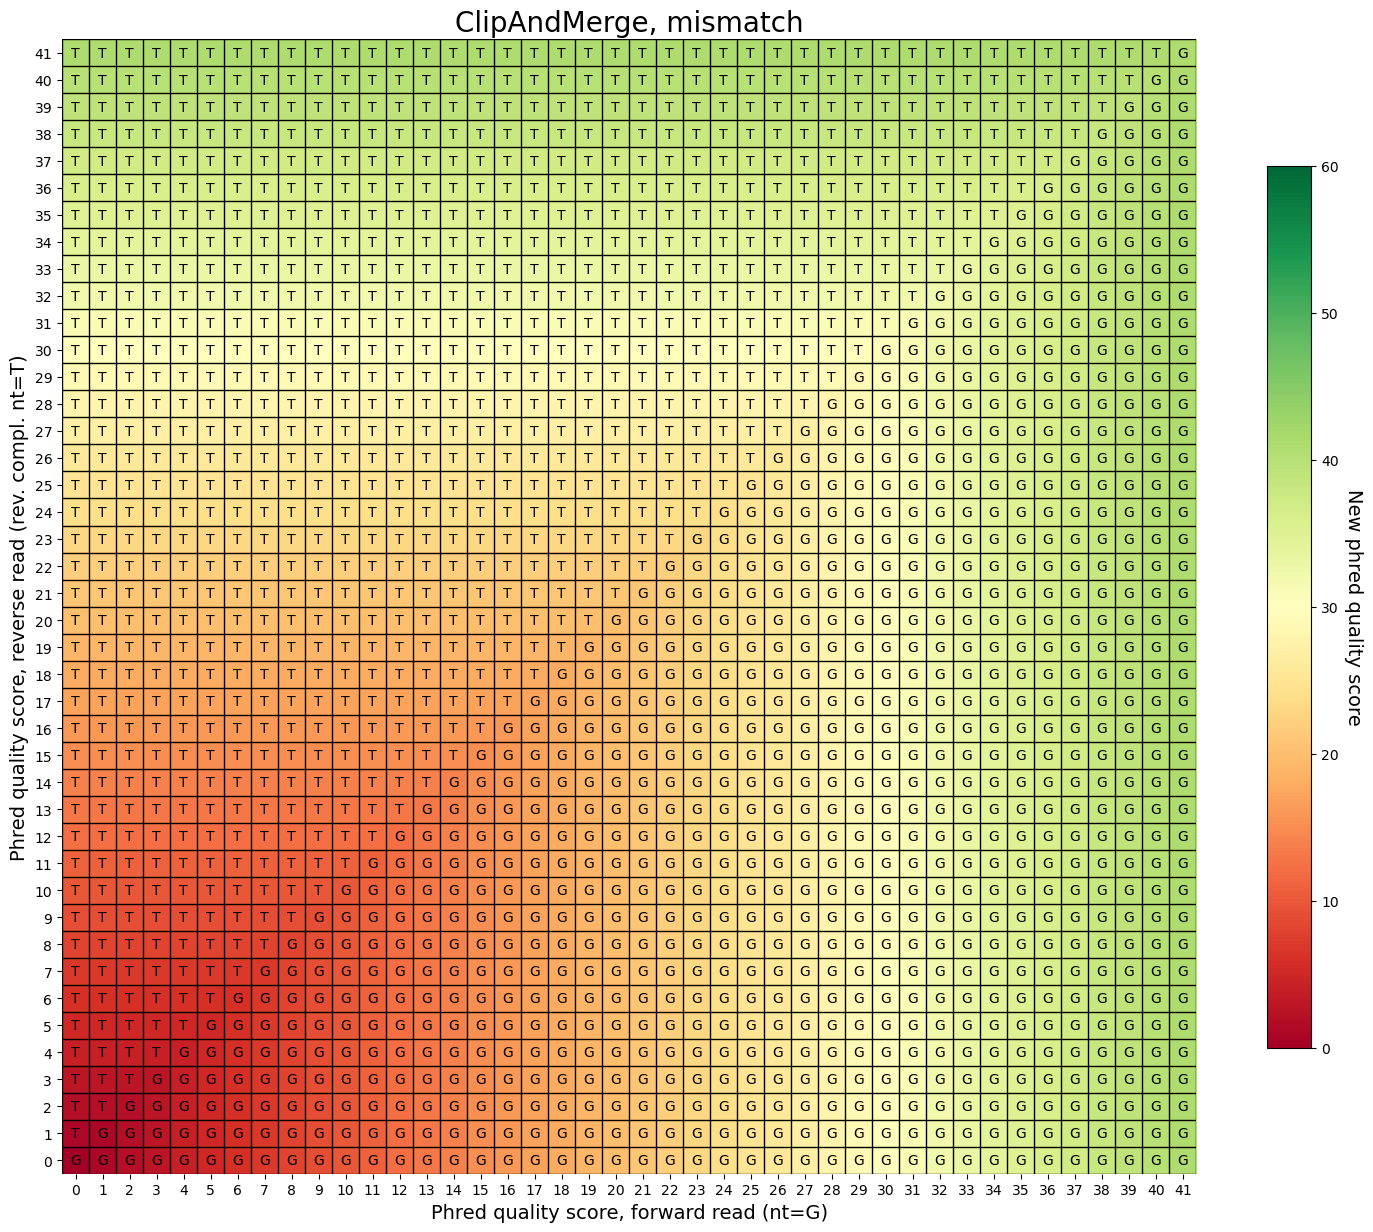

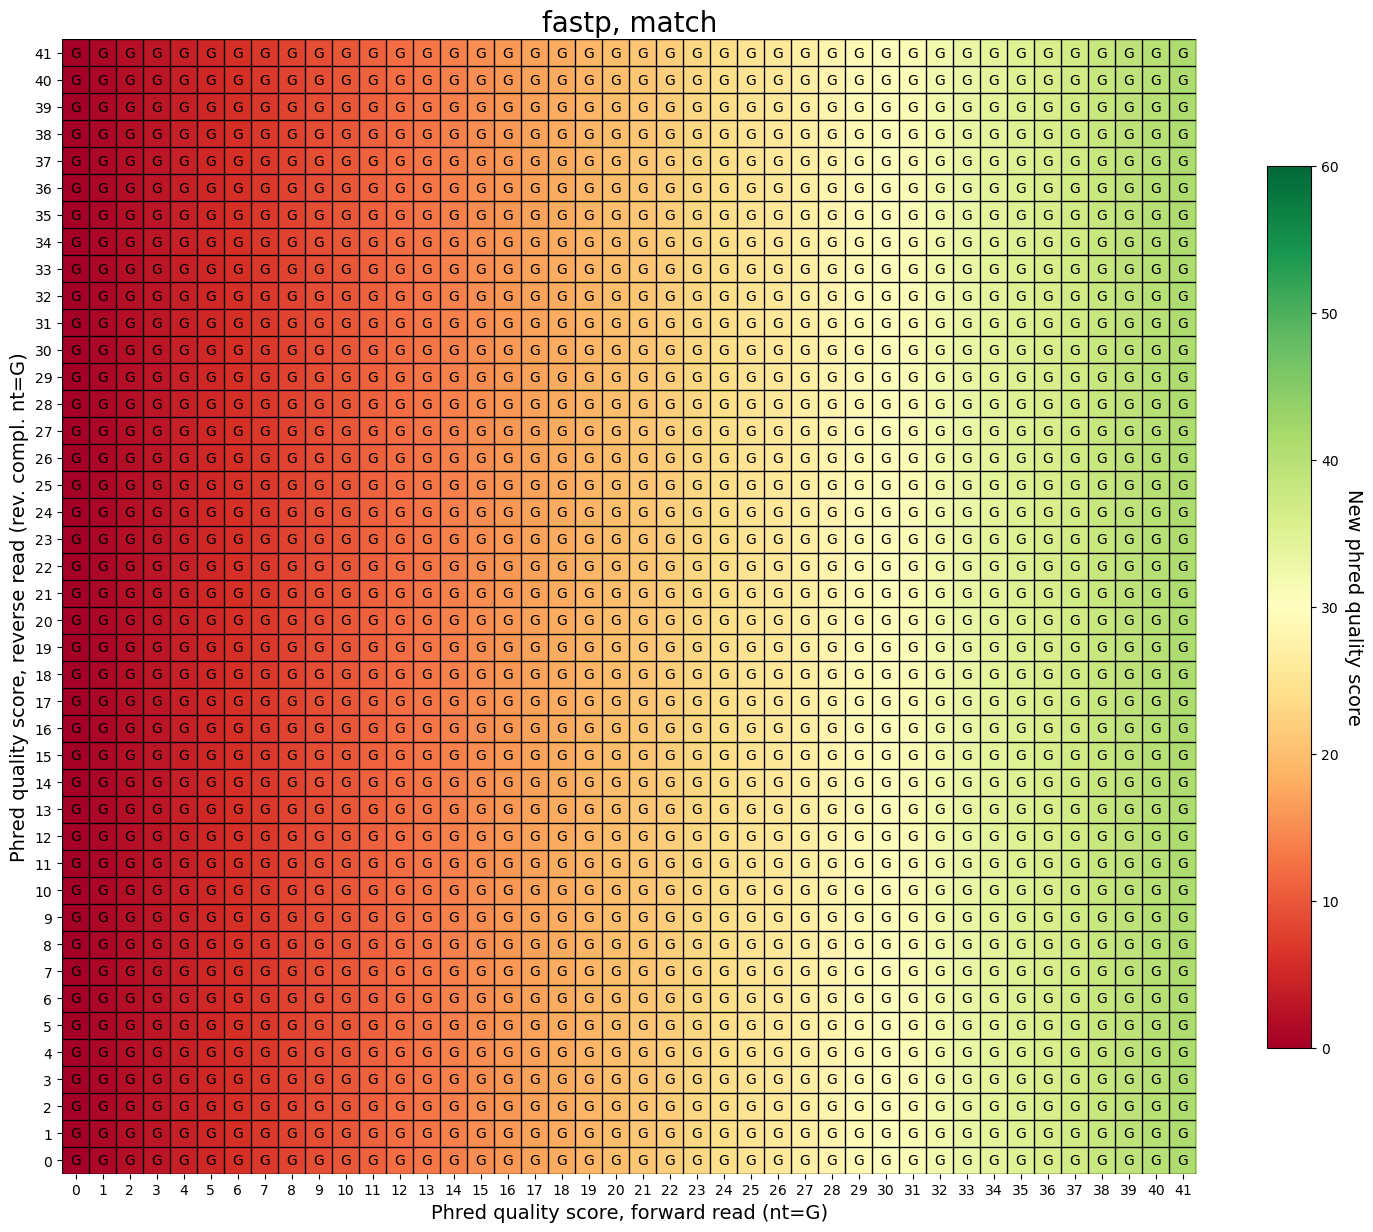

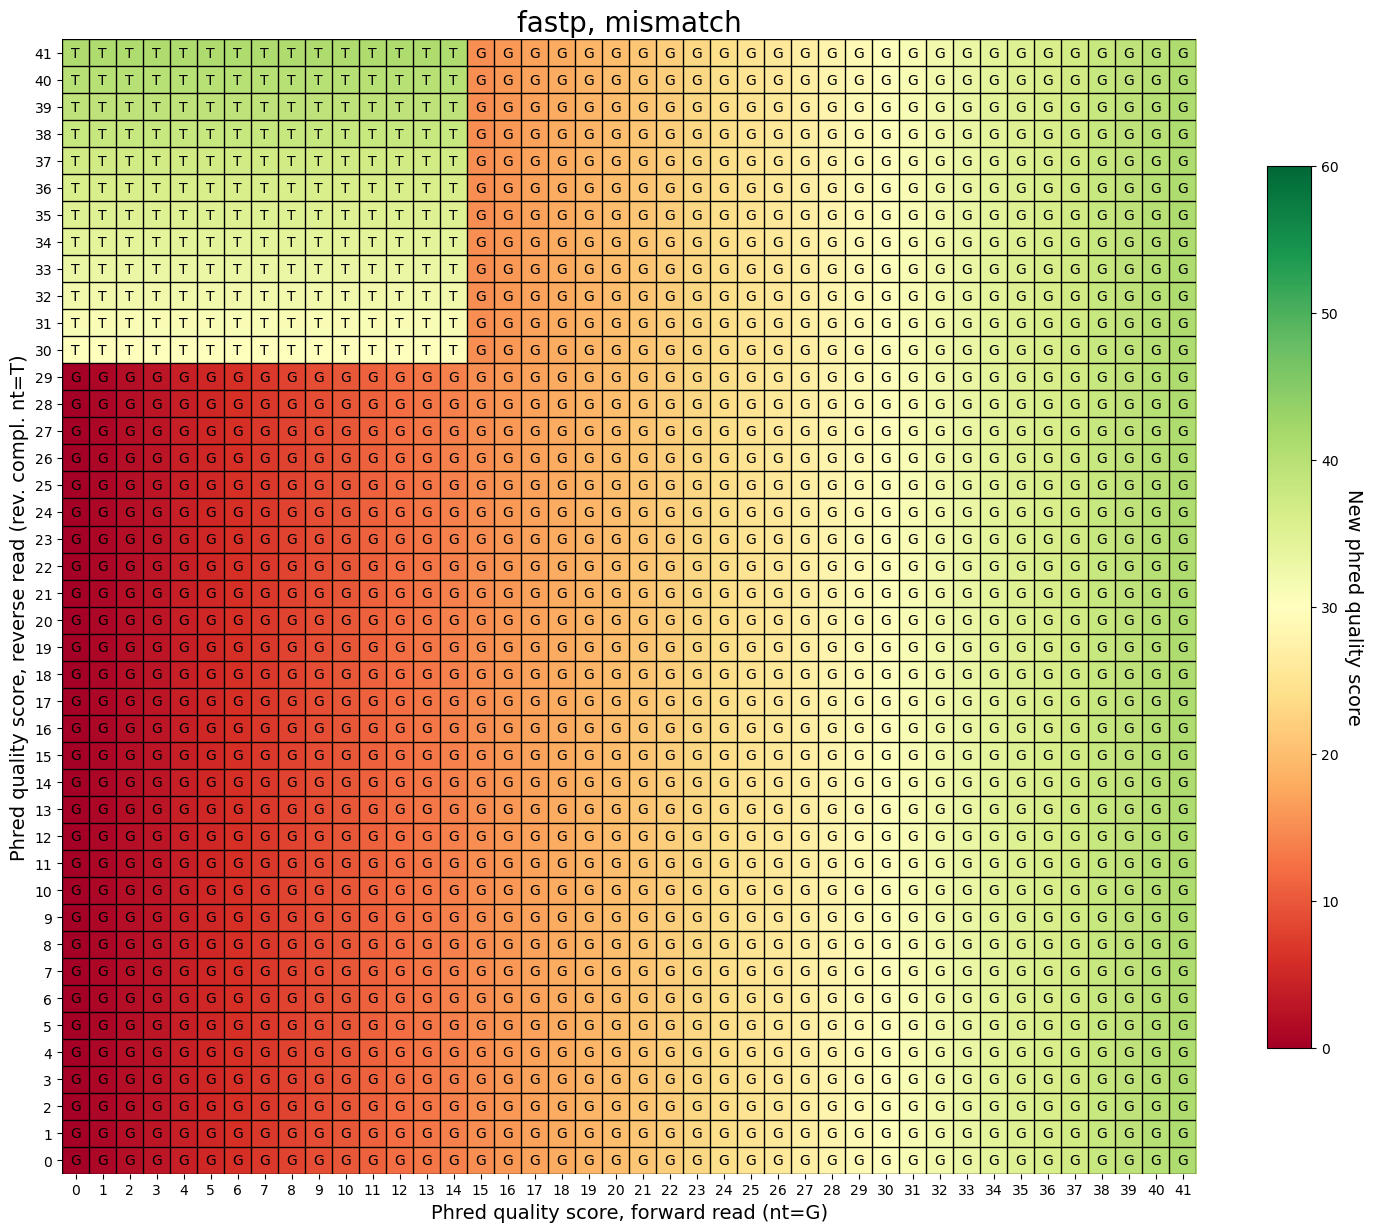

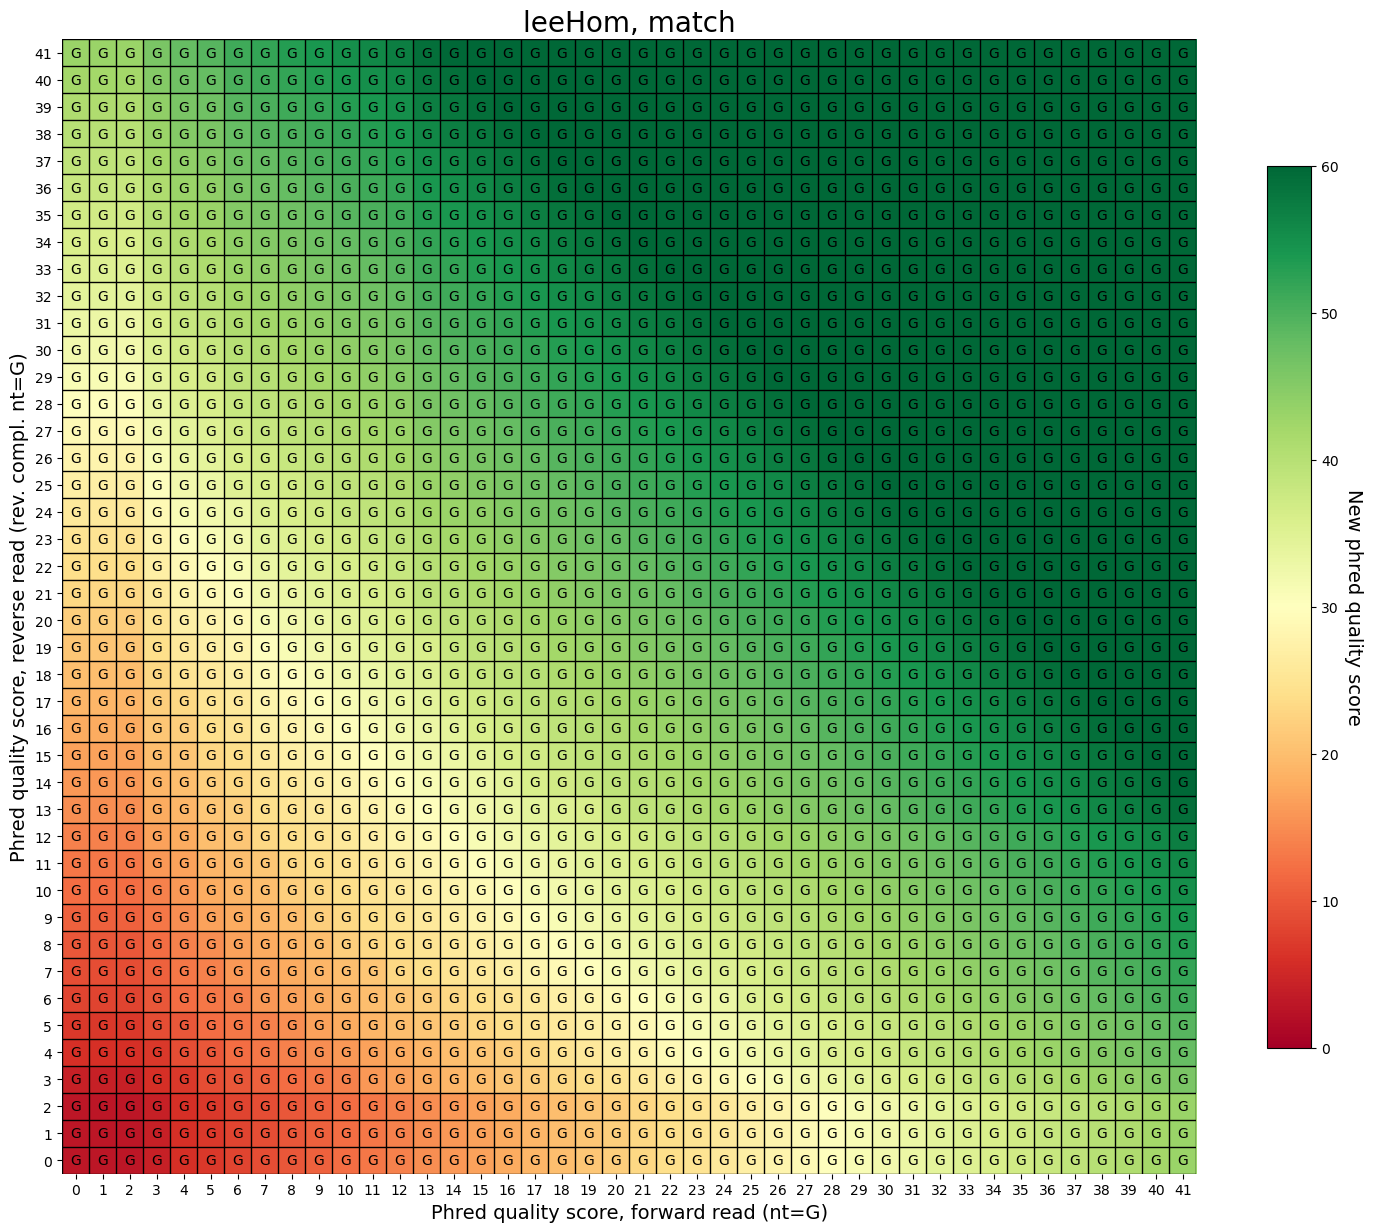

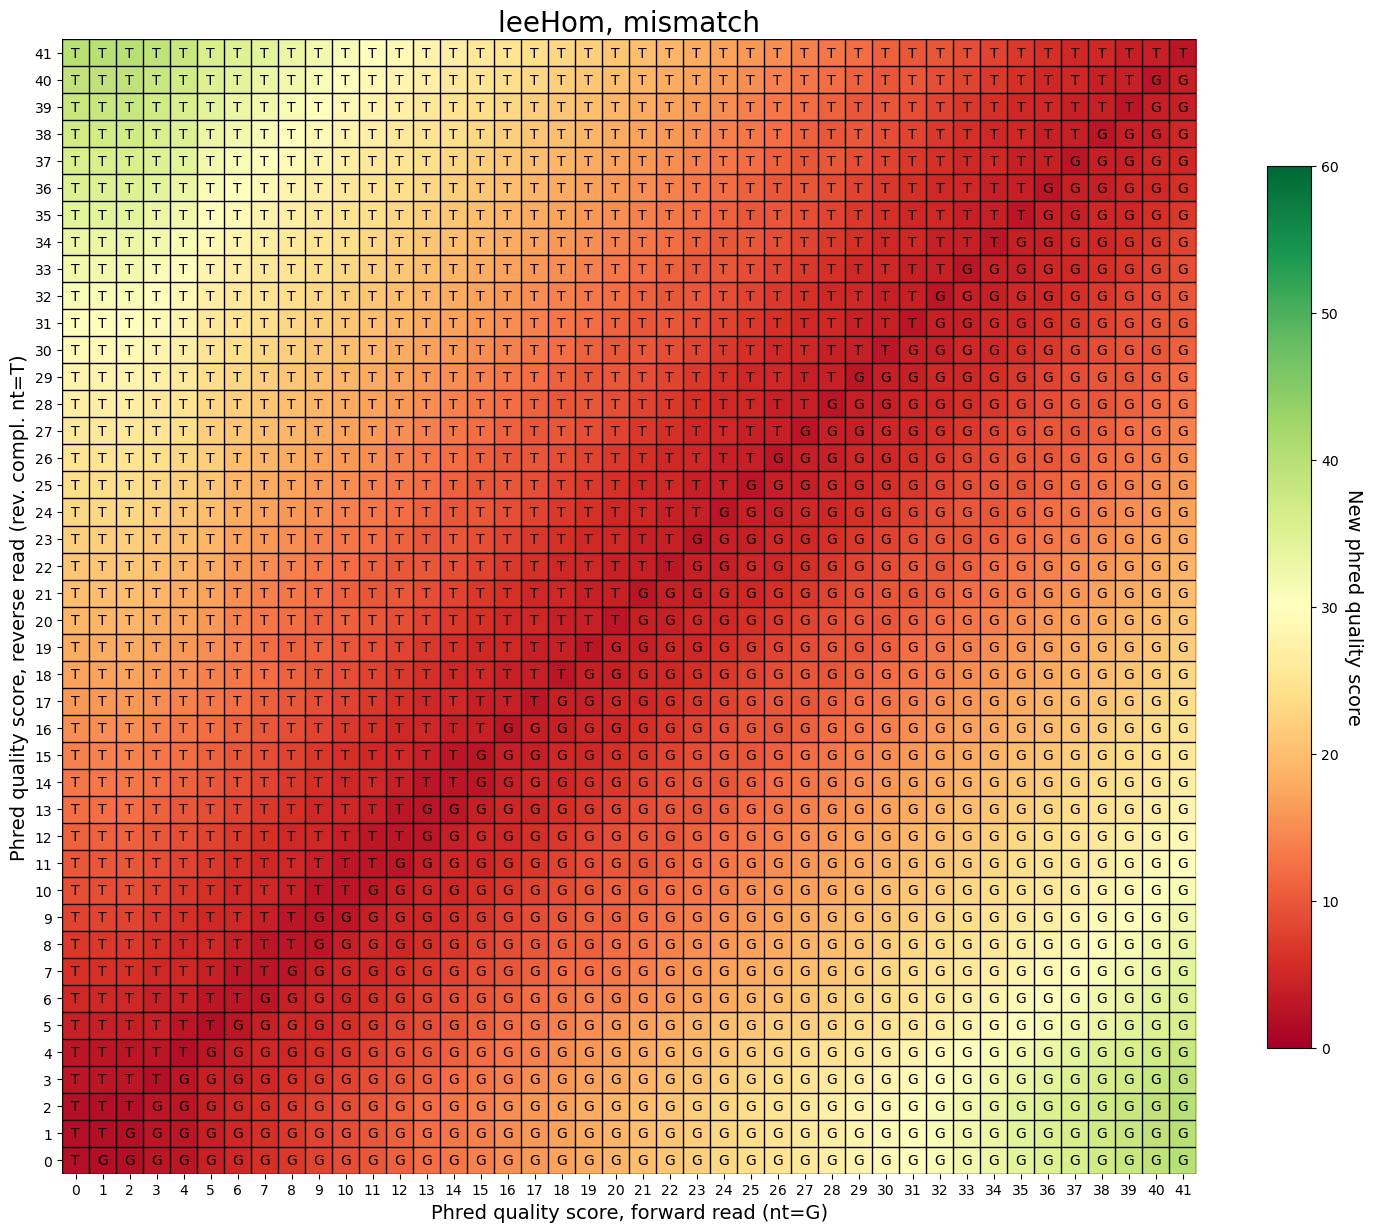

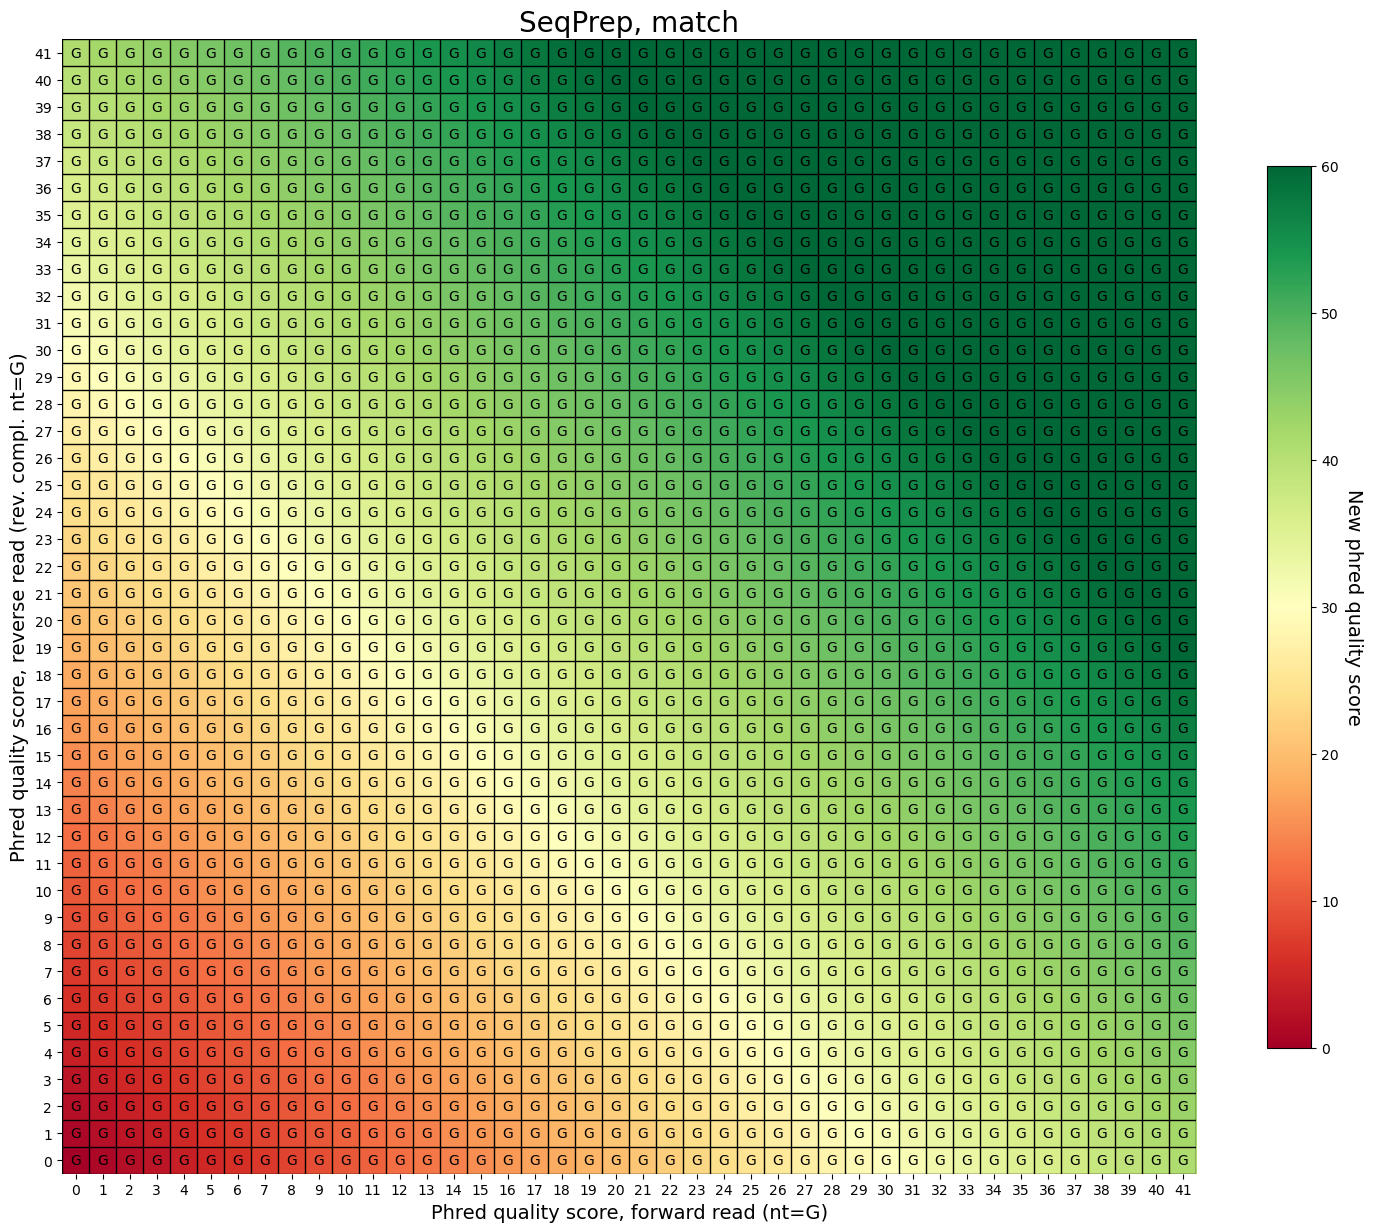

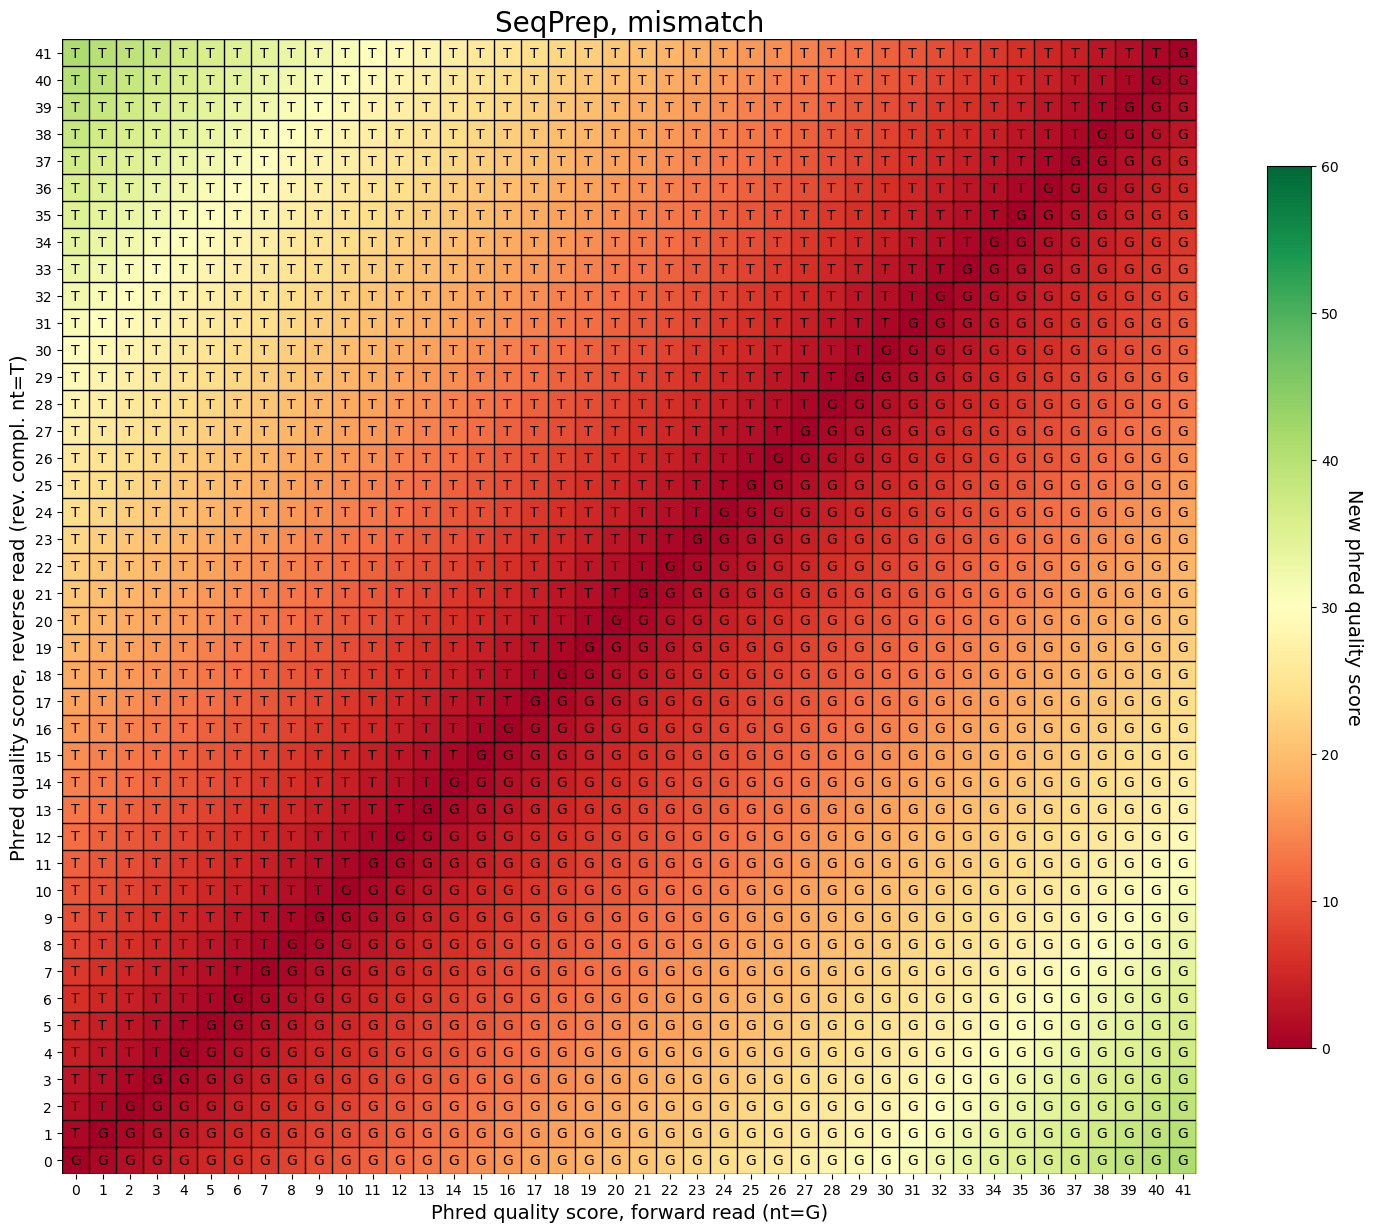

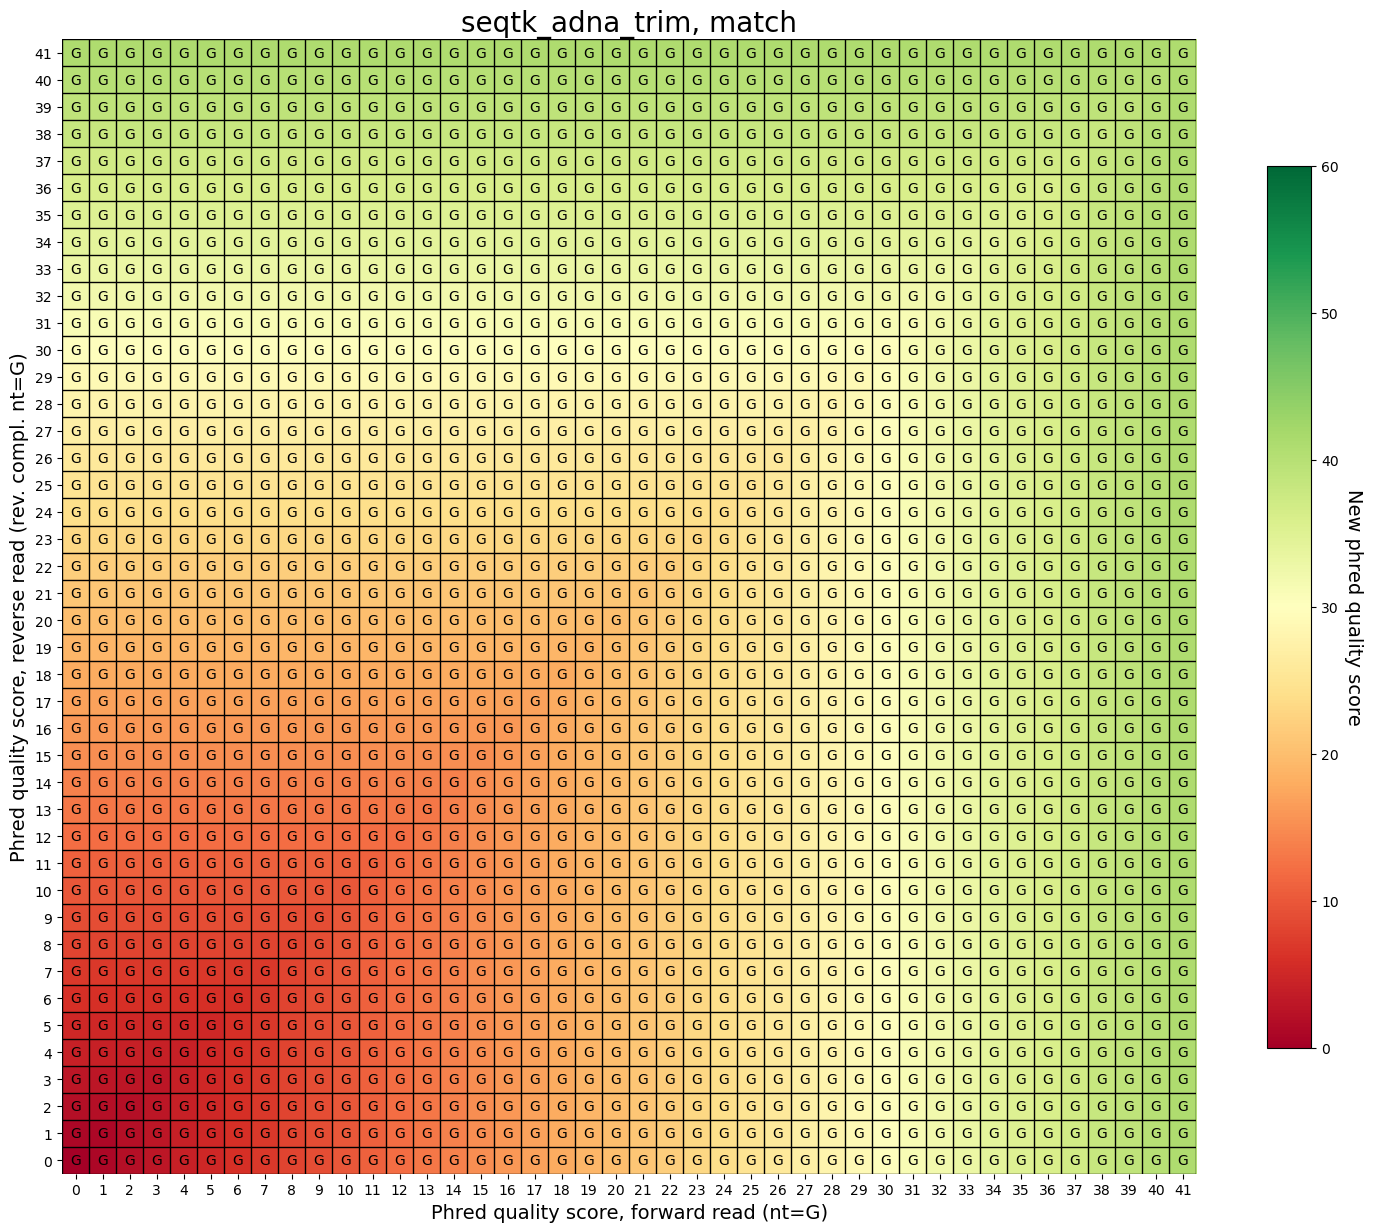

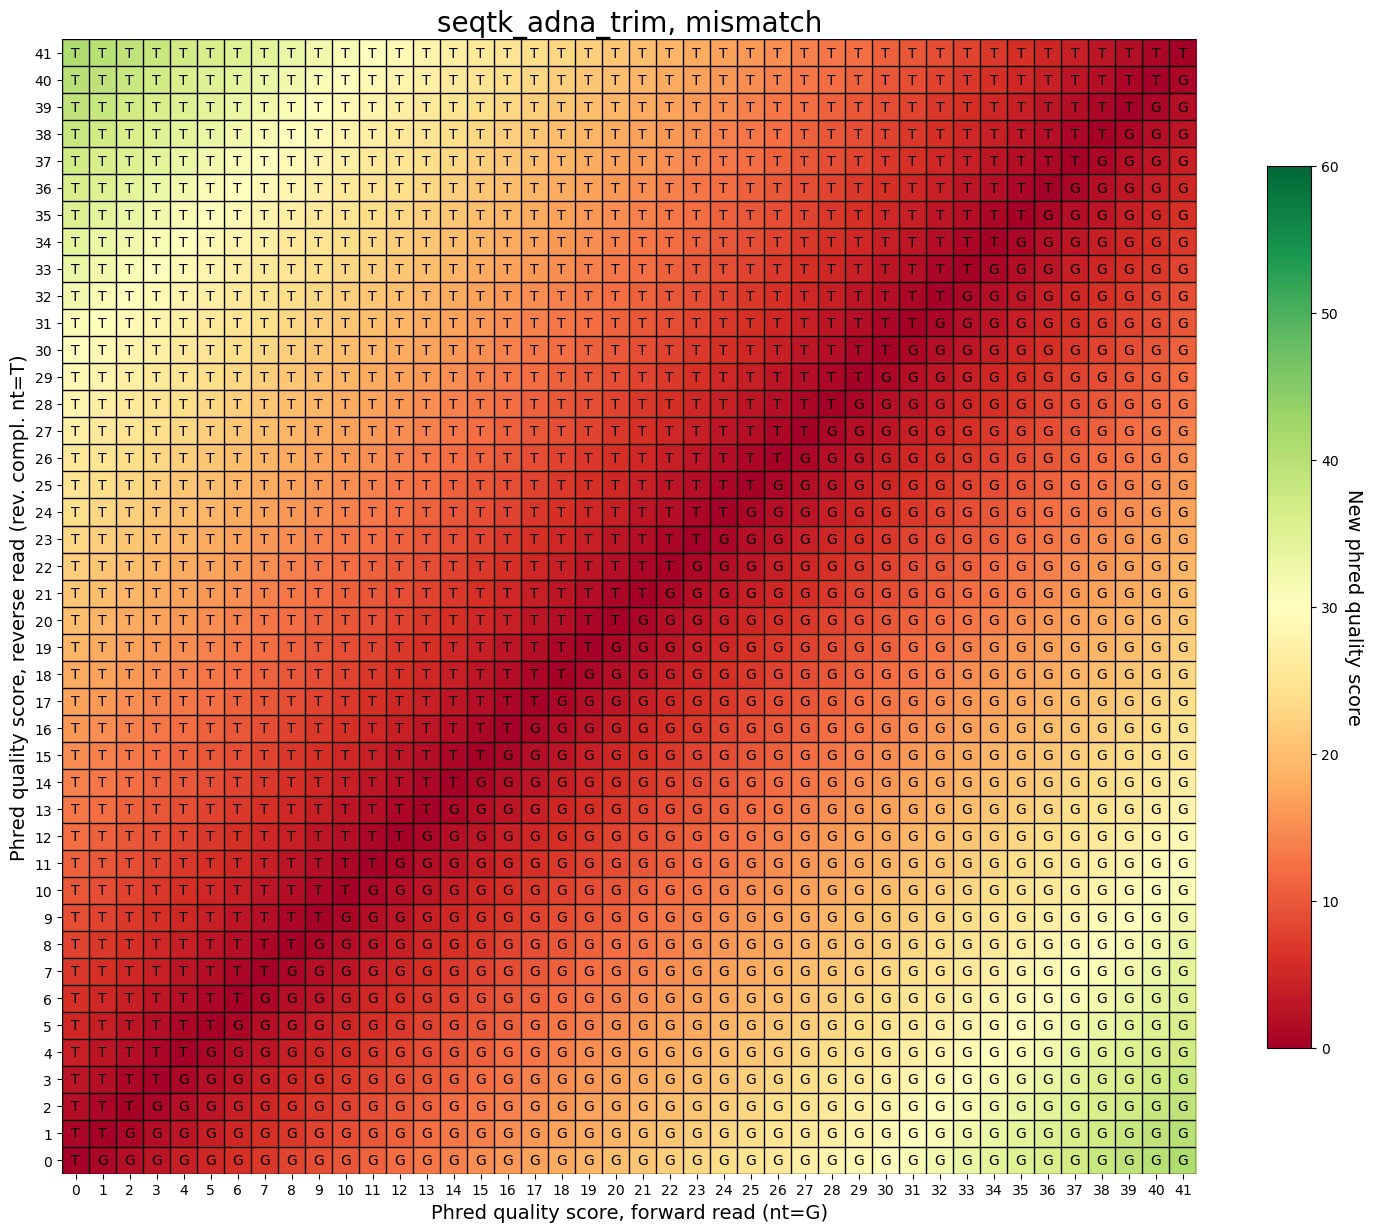

In [13]:
infile = "/mnt/c/Users/s202633/Documents/Master thesis/DNA_reconstruct/merge_phred/output/evaluation/all_qs.csv"
outdir = None

df = pd.read_csv(infile)
max_new_qs = max(df["new_qs"])

for program in list(df["program"].unique()):
    for match_type in ["match", "mismatch"]:
        mask = (df["program"] == program) & (df["type"] == match_type)
        df_type = df[mask]
        create_plots(df_type, program, match_type, max_new_qs, outdir)